In [36]:
import pandas as pd
import random 
import json
import math

from functions import join_stocks_crypto, generate_rand_portfolios
from functions_post_clustering import simulate_evaluate_portfolio_subset, reoptimize_weights, kruskal_anova_test, dunn_bonferroni, run_simulation

In [2]:
#GET THE DATA IN
df_all_stocks = pd.read_csv('stocks_data_filled.csv',index_col='Date')
cryptos_df = pd.read_csv('cryptos_data.csv', index_col='Date')

joined_df = join_stocks_crypto(cryptos_df, df_all_stocks, mode = 'stocks_left') #mode - either do left with crypto and fill NA for stocks or do left on stocks and leave out some dates for cryptos
joined_df.index = pd.to_datetime(joined_df.index)

returns_all = joined_df.pct_change()


tickers = list(df_all_stocks.columns)

random.seed(42)
random_portfolios = generate_rand_portfolios(n_reps=1000, n_stocks=15, tickers=tickers)


#Reassemble the portfolio jsons for minvar
min_var_portfolios = dict()
for i in range(1,1000):
    with open(f'min_variance_portfolio_jsons/my_dict{i}.json') as f:
        port = json.load(f)
        min_var_portfolios.update(port)

# with open(f"full_optimized_min_variance.json", "w") as f:
#     json.dump(min_var_portfolios, f, indent=4)

rand_ports_normal = random_portfolios.copy()
rand_ports_maxsharpe = reoptimize_weights(joined_df, random_portfolios, how='max_sharpe', min_weight=0.01)
rand_ports_equal_weights = reoptimize_weights(joined_df, random_portfolios, how='equal_weights', min_weight=0.01)

minvar_port_normal = min_var_portfolios.copy()
minvar_ports_maxsharpe = reoptimize_weights(joined_df, min_var_portfolios, how='max_sharpe', min_weight=0.01)
minvar_ports_equal_weights = reoptimize_weights(joined_df, min_var_portfolios, how='equal_weights', min_weight=0.01)


with open('all_optimized_sets_for_simulation.json') as f:
    crypto_supplemented_sets = json.load(f)


portfolio_sets = {'rand_ports_normal': rand_ports_normal,
                  'rand_ports_maxsharpe': rand_ports_maxsharpe, 
                  'rand_ports_equal_weights': rand_ports_equal_weights,
                  'minvar_port_normal': minvar_port_normal,  
                  'minvar_ports_maxsharpe': minvar_ports_maxsharpe, 
                  'minvar_ports_equal_weights': minvar_ports_equal_weights}

all_sets = portfolio_sets | crypto_supplemented_sets

In [41]:
portfolio_no_crypto_to_test = portfolio_sets['minvar_port_normal']['portfolio_1']
portfolio_no_crypto_to_test

{'PEP': 0.0770928176769716,
 'TLK': 0.0936368846230521,
 'ULVR.L': 0.0474024863914366,
 'AD.AS': 0.068402154962365,
 'KPN.AS': 0.1675608716400122,
 '600519.SS': 0.0430476659121988,
 '600941.SS': 0.01,
 '601398.SS': 0.1629030909490932,
 '601857.SS': 0.0110428598729044,
 '2914.T': 0.0595276588232024,
 '8001.T': 0.01,
 '9432.T': 0.0679188682788836,
 '9434.T': 0.1319492246057224,
 '0883.HK': 0.01,
 '6288.HK': 0.0395154162641574}

In [42]:
portfolio_with_crypto_to_test = crypto_supplemented_sets['minvar_w_cryptos_ahc_equalw']['portfolio_1']
portfolio_with_crypto_to_test

{'PEP': 0.05555555555555555,
 'TLK': 0.05555555555555555,
 'ULVR.L': 0.05555555555555555,
 'AD.AS': 0.05555555555555555,
 'KPN.AS': 0.05555555555555555,
 '600519.SS': 0.05555555555555555,
 '600941.SS': 0.05555555555555555,
 '601398.SS': 0.05555555555555555,
 '601857.SS': 0.05555555555555555,
 '2914.T': 0.05555555555555555,
 '8001.T': 0.05555555555555555,
 '9432.T': 0.05555555555555555,
 '9434.T': 0.05555555555555555,
 '0883.HK': 0.05555555555555555,
 '6288.HK': 0.05555555555555555,
 'INJ-USD': 0.05555555555555555,
 'UNI-USD': 0.05555555555555555,
 'APE-USD': 0.05555555555555555}

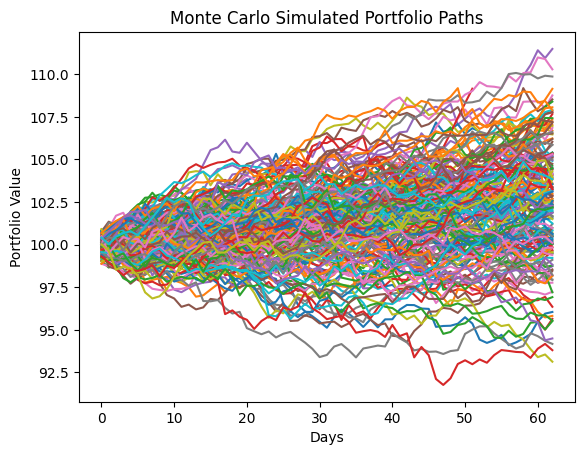

In [ ]:
portfolio_sims_nocrypto = run_simulation(portfolio_no_crypto_to_test, returns_all, n_sims=200, t=63, distribution_model='multivar_norm', plot=True, initialPortfolio=100)

In [43]:
keys_to_remove = ['INJ-USD', 'APE-USD', 'UNI-USD']
#filtered_dict = {k: v for k, v in portfolio_with_crypto_to_test.items() if k not in keys_to_remove}
#filtered_dict
rounded_dict = {k: math.floor(v * 1e8) / 1e8 for k, v in portfolio_with_crypto_to_test.items()}
sum(rounded_dict.values())

0.9999999

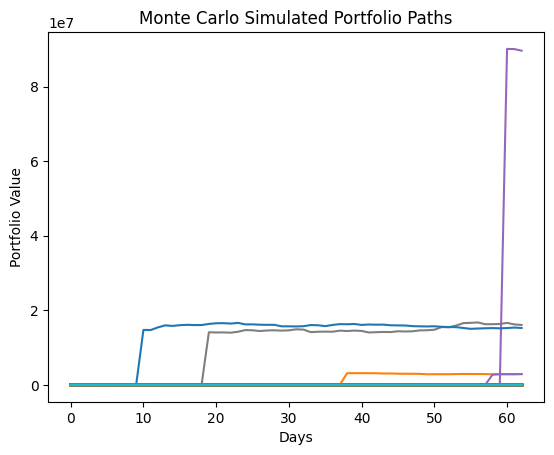

In [47]:
portfolio_sims_withcrypto = run_simulation(rounded_dict, returns_all, n_sims=200, t=63, distribution_model='bootstrap', plot=True, initialPortfolio=100)

In [55]:
pd.set_option('display.max_rows', 100)
returns_all[['INJ-USD','UNI-USD', 'APE-USD']]

,INJ-USD,UNI-USD,APE-USD
Date,,,
2022-01-03,NaN,NaN,NaN
2022-01-04,-0.015370,-0.007194,-0.003108
2022-01-05,-0.064836,0.891304,0.053982
2022-01-06,-0.024930,-0.007663,0.007889
2022-01-07,-0.064113,-0.038610,-0.030484
...,...,...,...
2023-12-25,0.121261,-0.009091,0.058608
2023-12-26,-0.102121,-0.022936,-0.048414
2023-12-27,0.009896,0.018779,0.015967


SIMULATE AND EVALUATE

In [ ]:
# subset_statistics_results_dfs = dict()
# for key, portfolio_set in all_sets.items():
#     for time_period in [63]:#, 126, 189, 252]:
#         print(f'simulating {key}')
#         simulations_results_dict, subset_statistics_df, _ = simulate_evaluate_portfolio_subset(portfolio_set, returns_all, n_sims=200, t=time_period, distribution_model='multivar_norm')
#         subset_statistics_results_dfs[f'{key}_period{time_period}'] = subset_statistics_df


# simulations_results_dict_rand, subset_statistics_df_rand, _ = simulate_evaluate_portfolio_subset(random_portfolios, returns_all, n_sims=100, t=100, distribution_model='multivar_norm')

# simulations_results_dict_minvar, subset_statistics_df_minvar, _ = simulate_evaluate_portfolio_subset(min_var_portfolios, returns_all, n_sims=100, t=100, distribution_model='multivar_norm')

simulating rand_ports_normal
simulating rand_ports_maxsharpe
simulating rand_ports_equal_weights
simulating minvar_port_normal
simulating minvar_ports_maxsharpe
simulating minvar_ports_equal_weights
simulating random_w_cryptos_kmeans_equalw


c:\Users\Kirill\Documents\Projects\thesis\venv312\Lib\site-packages\scipy\stats\_stats_py.py:1202: RuntimeWarning: overflow encountered in square
  s = s**2


simulating random_w_cryptos_kmeans_maxsharpe


c:\Users\Kirill\Documents\Projects\thesis\venv312\Lib\site-packages\scipy\stats\_stats_py.py:1204: RuntimeWarning: overflow encountered in multiply
  s *= a_zero_mean
c:\Users\Kirill\Documents\Projects\thesis\venv312\Lib\site-packages\numpy\_core\_methods.py:135: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
c:\Users\Kirill\Documents\Projects\thesis\venv312\Lib\site-packages\scipy\stats\_stats_py.py:1202: RuntimeWarning: overflow encountered in square
  s = s**2


simulating random_w_cryptos_kshape_equalw


c:\Users\Kirill\Documents\Projects\thesis\venv312\Lib\site-packages\scipy\stats\_stats_py.py:1202: RuntimeWarning: overflow encountered in square
  s = s**2


simulating random_w_cryptos_kshape_maxsharpe
simulating random_w_cryptos_ahc_equalw


c:\Users\Kirill\Documents\Projects\thesis\venv312\Lib\site-packages\scipy\stats\_stats_py.py:1202: RuntimeWarning: overflow encountered in square
  s = s**2


simulating random_w_cryptos_ahc_maxsharpe


c:\Users\Kirill\Documents\Projects\thesis\venv312\Lib\site-packages\scipy\stats\_stats_py.py:1204: RuntimeWarning: overflow encountered in multiply
  s *= a_zero_mean
c:\Users\Kirill\Documents\Projects\thesis\venv312\Lib\site-packages\numpy\_core\_methods.py:135: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
c:\Users\Kirill\Documents\Projects\thesis\venv312\Lib\site-packages\scipy\stats\_stats_py.py:1202: RuntimeWarning: overflow encountered in square
  s = s**2


simulating random_w_cryptos_random_equalw


c:\Users\Kirill\Documents\Projects\thesis\venv312\Lib\site-packages\scipy\stats\_stats_py.py:1202: RuntimeWarning: overflow encountered in square
  s = s**2


simulating random_w_cryptos_random_maxsharpe


c:\Users\Kirill\Documents\Projects\thesis\venv312\Lib\site-packages\scipy\stats\_stats_py.py:1202: RuntimeWarning: overflow encountered in square
  s = s**2


simulating minvar_w_cryptos_kmeans_equalw


c:\Users\Kirill\Documents\Projects\thesis\venv312\Lib\site-packages\scipy\stats\_stats_py.py:1202: RuntimeWarning: overflow encountered in square
  s = s**2


simulating minvar_w_cryptos_kmeans_maxsharpe
simulating minvar_w_cryptos_kshape_equalw


c:\Users\Kirill\Documents\Projects\thesis\venv312\Lib\site-packages\scipy\stats\_stats_py.py:1202: RuntimeWarning: overflow encountered in square
  s = s**2


simulating minvar_w_cryptos_kshape_maxsharpe
simulating minvar_w_cryptos_ahc_equalw


c:\Users\Kirill\Documents\Projects\thesis\venv312\Lib\site-packages\scipy\stats\_stats_py.py:1202: RuntimeWarning: overflow encountered in square
  s = s**2


simulating minvar_w_cryptos_ahc_maxsharpe
simulating minvar_w_cryptos_random_equalw


c:\Users\Kirill\Documents\Projects\thesis\venv312\Lib\site-packages\scipy\stats\_stats_py.py:1202: RuntimeWarning: overflow encountered in square
  s = s**2


simulating minvar_w_cryptos_random_maxsharpe


c:\Users\Kirill\Documents\Projects\thesis\venv312\Lib\site-packages\scipy\stats\_stats_py.py:1202: RuntimeWarning: overflow encountered in square
  s = s**2


In [8]:
subset_statistics_results_dfs['minvar_port_normal_period63']#.keys()

,mean_cumulative_return,mean_daily_return,std_cumulative_return,std_daily_return,sharpe_daily,sharpe_cumulative,sharpe_annual,sharpe_cumulative_annual,VaR,CVaR,sortino,sortino_annual
0,0.024110,0.000389,0.034456,0.004070,0.056544,0.418325,0.897601,6.640696,2.842281,4.782315,0.084012,1.333654
1,0.035313,0.000570,0.032756,0.004280,0.096001,0.782065,1.523968,12.414898,1.947432,3.307646,0.145923,2.316460
2,0.027698,0.000447,0.030705,0.004013,0.071759,0.586260,1.139143,9.306586,2.332640,3.387998,0.107465,1.705947
3,0.025108,0.000405,0.030563,0.004005,0.061480,0.504261,0.975963,8.004898,2.464157,3.871033,0.091547,1.453258
4,0.038047,0.000614,0.040846,0.005255,0.086570,0.694098,1.374251,11.018459,3.437975,4.823653,0.131174,2.082319
...,...,...,...,...,...,...,...,...,...,...,...,...
994,0.058214,0.000939,0.050240,0.006112,0.127651,0.965715,2.026402,15.330253,3.143484,5.179143,0.200789,3.187429
995,0.023725,0.000383,0.033771,0.004081,0.054875,0.415415,0.871118,6.594514,3.034590,4.912105,0.081487,1.293571
996,0.039158,0.000632,0.043883,0.005394,0.087666,0.671355,1.391647,10.657430,2.995266,5.091138,0.133310,2.116224
997,0.027337,0.000441,0.027615,0.004041,0.069836,0.638793,1.108613,10.140527,1.718108,2.807946,0.104607,1.660592


In [13]:
subset_statistics_results_dfs['random_w_cryptos_kmeans_maxsharpe_period63']#.keys()

,mean_cumulative_return,mean_daily_return,std_cumulative_return,std_daily_return,sharpe_daily,sharpe_cumulative,sharpe_annual,sharpe_cumulative_annual,VaR,CVaR,sortino,sortino_annual
0,60.307380,0.972700,123.498156,17.299003,0.056219,0.488248,0.892457,7.750691,1.656360e+68,1.192493e+72,0.083106,1.319265
1,77.476237,1.249617,139.025504,17.277861,0.072316,0.557211,1.147974,8.845450,3.903836e+66,3.676157e+67,0.109036,1.730891
2,36.305479,0.585572,112.218450,13.860714,0.042235,0.323439,0.670467,5.134429,8.245127e+61,1.067522e+67,0.061475,0.975884
3,66.316370,1.069619,147.143869,17.628238,0.060667,0.450625,0.963066,7.153447,1.180704e+67,4.177902e+71,0.090475,1.436251
4,44.607818,0.719481,106.743340,13.681533,0.052576,0.417807,0.834620,6.632481,2.295155e+60,2.302815e+63,0.077876,1.236244
...,...,...,...,...,...,...,...,...,...,...,...,...
995,53.167269,0.857537,93.803920,13.776600,0.062234,0.566688,0.987940,8.995896,4.654748e+61,5.744701e+63,0.092650,1.470772
996,33.204780,0.535561,107.839482,13.787032,0.038834,0.307819,0.616467,4.886481,5.064182e+60,1.073333e+65,0.056800,0.901667
997,72.297242,1.166085,137.237718,17.681588,0.065940,0.526732,1.046767,8.361617,1.485796e+67,3.347622e+70,0.098668,1.566308
998,43.670366,0.704361,102.432147,13.707229,0.051374,0.426240,0.815545,6.766349,4.664914e+61,6.787025e+65,0.075641,1.200764


In [ ]:
# subset_stats_dfs = {'Random Portfolios Stats': subset_statistics_df_rand,
#                     'MinVar Portfolios Stats': subset_statistics_df_minvar}
# subset_stats_dfs = subset_statistics_results_dfs

# kruskal_anova_test(subset_stats_dfs, metrics='all', test='kruskal')

,test_stat,test_p
mean_cumulative_return,180.3194,0.0
mean_daily_return,180.3194,0.0
std_cumulative_return,1210.8222,0.0
std_daily_return,1208.9945,0.0
sharpe_daily,392.0214,0.0
sharpe_cumulative,397.0952,0.0
sharpe_annual,392.0214,0.0
sharpe_cumulative_annual,397.0952,0.0
VaR,1366.6781,0.0
CVaR,1334.6594,0.0


In [ ]:
# subset_stats_dfs = {'Random Portfolios Stats': subset_statistics_df_rand,
#                     'MinVar Portfolios Stats': subset_statistics_df_minvar}

# x = dunn_bonferroni(subset_stats_dfs, metrics='all')
# x

{'mean_cumulative_return':                    MinVar Portfolios  Random Portfolios
 MinVar Portfolios                1.0                0.0
 Random Portfolios                0.0                1.0,
 'mean_daily_return':                    MinVar Portfolios  Random Portfolios
 MinVar Portfolios                1.0                0.0
 Random Portfolios                0.0                1.0,
 'std_cumulative_return':                    MinVar Portfolios  Random Portfolios
 MinVar Portfolios                1.0                0.0
 Random Portfolios                0.0                1.0,
 'std_daily_return':                    MinVar Portfolios  Random Portfolios
 MinVar Portfolios                1.0                0.0
 Random Portfolios                0.0                1.0,
 'sharpe_daily':                    MinVar Portfolios  Random Portfolios
 MinVar Portfolios                1.0                0.0
 Random Portfolios                0.0                1.0,
 'sharpe_cumulative':           